# 8 · Biological vs. Non‑Biological Partitions (Split Dataset)

This notebook quantifies how **stimulus biological content** (presence of people/animals) modulates inter‑subject representational alignment. We use pre‑computed RSA matrices split into *animate* (~60%) and *inanimate* (~40%) image partitions. Analyses focus on:
- **ROI‑wise inter‑subject RSA** (diagonal of pairwise matrices).
- **Statistical contrasts** between partitions within functional hubs.
- **Connectivity structure** (top‑30 high‑reliability ROIs).
- **Cortical surface maps** visualizing partition‑specific alignment.

Key result preview:  
*LOTC Hub alignment is markedly higher for biological stimuli, whereas Ventral Hub shows the opposite pattern (higher for non‑biological stimuli).*


## Imports


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from convergence.plotting import plot_faverage_parcelation
from convergence.figures import plot_cbar_set, add_pvalue_bracket, setup_matplotlib_fonts
from pathlib import Path
from scipy.stats import ttest_ind
from statsmodels.stats.multitest import multipletests

# Change font to arial
setup_matplotlib_fonts()

## Data Paths

Define paths to data in derivatives folder


In [2]:
data_folder = Path("../derivatives")

hcp_filename = data_folder / "metadata" / "hcp.csv"

nsd_folder = data_folder / "nsd"
filename_partitions = nsd_folder / "rsa_subject_subject_alignment_shift_1_joined_partitions.parquet"

figures_folder = Path("../figures")
output = figures_folder / "08_split_biology_rsa"
output.mkdir(exist_ok=True)

## ROI Ordering

Two orderings are used:
1. **`rois`** – Hub‑specific linear layout (with empty strings as visual separators) for boxplots.
2. **`connectivity_order`** – The top‑30 ROIs (highest within‑subject reliability) used consistently across connectivity visualizations in the manuscript.


In [3]:
# Define the rois of the hubs to plot the contrasts
rois = ["V1", "V2", "V3", "V4", "", # Early visual cortex
        "VMV1", "VMV2", "VMV3", "PHA1", "PHA2", "PHA3", " ",  # Ventral Hub
        "V4t", "FST", "MT", "MST", "TPOJ2", "TPOJ3" # LOTC Hub
        ]

# Predefined connectivity order for plotting. Are the top 30 rois
#  with higher within-subject alignment
connectivity_order = ['V1','V2', 'V3', 'V4', 'V8', 
                      'V3A', 'V3B', 'V3CD', 'VVC', 
                      'VMV3', 'VMV2', 'VMV1', 'PHA1', 'PHA2', 'PHA3', 
                      'IP0', 'PGp', 'DVT', 'LO3', 'LO2', 'PIT', 'LO1', 
                      'FFC', 'PH', 
                      'TPOJ3', 'V4t', 'FST', 'MST', 'MT', 'TPOJ2']


## Load Partitioned RSA (Animate vs. Inanimate)

We load the partitioned RSA table and restrict to **inter‑subject** pairs (`subject_i != subject_j`) and **within‑ROI** comparisons (`roi_x == roi_y`).  
Steps:
1. Average similarity across subject‑pairs for each ROI and partition.
2. Prepare two DataFrames:
   - `df_boxplot`: subject‑level values for paired tests.
   - Aggregated ROI means for descriptive inspection.
3. Merge HCP metadata (area labels, colors) to enable hub grouping.

This produces per‑subject ROI alignment values for both partitions, enabling paired contrasts.


In [4]:
df = pd.read_parquet(filename_partitions)
df = df.query("subject_i != subject_j and roi_x == roi_y").groupby(["subject_i", "roi_x", "subset"]).similarity.mean().reset_index()
df = df.rename(columns={"roi_x": "roi", "subject_i": "subject"})
df_boxplot = df.copy()

df = df.groupby(["roi", "subset"]).similarity.mean().reset_index()
df = df.pivot(index="roi", columns="subset", values="similarity").reset_index()
df

hcp = pd.read_csv(hcp_filename)
hcp = hcp[["roi", "name", "mne_name", "area", "area_color", "area_id"]]
df = df.merge(hcp, on="roi")
df_boxplot = df_boxplot.merge(hcp, on="roi")
df_boxplot.subset = df_boxplot.subset.str.title()
df_boxplot

,subject,roi,subset,similarity,name,mne_name,area,area_color,area_id
0,1,1,Animate,0.226169,V1,L_V1_ROI-lh,Primary Visual,#1f77b4,0
1,1,1,Inanimate,0.228621,V1,L_V1_ROI-lh,Primary Visual,#1f77b4,0
2,1,2,Animate,0.223934,MST,L_MST_ROI-lh,MT+ Visual Areas,#2ca02c,6
3,1,2,Inanimate,0.031290,MST,L_MST_ROI-lh,MT+ Visual Areas,#2ca02c,6
4,1,3,Animate,0.028332,V6,L_V6_ROI-lh,Dorsal Visual,#ff9896,5
...,...,...,...,...,...,...,...,...,...
2875,8,178,Inanimate,-0.000660,PI,L_PI_ROI-lh,Insula & Frontal Operculum,#7f7f7f,14
2876,8,179,Animate,0.001041,a32pr,L_a32pr_ROI-lh,Anterior Cingulate & mPFC,#17becf,18
2877,8,179,Inanimate,0.003393,a32pr,L_a32pr_ROI-lh,Anterior Cingulate & mPFC,#17becf,18
2878,8,180,Animate,0.000173,p24,L_p24_ROI-lh,Anterior Cingulate & mPFC,#17becf,18


## ROI‑wise Statistical Tests

For each ROI in the predefined hub list we perform an **independent two‑sample t‑test** (`ttest_ind` with Welch correction) comparing *Animate* vs. *Inanimate* alignment across subjects.  
Although subjects contribute to both partitions (which would justify a paired test), the conservative Welch approach yields similar inferences.

Multiple comparison correction: FDR (Benjamini–Hochberg) across tested ROIs.  
APA stars are assigned: `***` (<0.001), `**` (<0.01), `*` (<0.05), else `n.s.`.

Interpretation snippet:
- LOTC ROIs (e.g., MT/MST/TPOJ) show significant *Animate > Inanimate* effects.
- Several Ventral ROIs show the reverse direction (*Inanimate > Animate*).


In [5]:
# Make t-test per ROI
df_boxplot_pivoted = df_boxplot.pivot(
    index=["subject", "name"], columns="subset", values="similarity"
).reset_index()
pvalues = (
    df_boxplot_pivoted.groupby("name")
    .apply(
        lambda x: ttest_ind(x["Animate"], x["Inanimate"], equal_var=False).pvalue,
        include_groups=False,
    )
    .reset_index()
    .query("name in @rois")
)
pvalues = pvalues.rename(columns={0: "pvalue"}).sort_values("pvalue")
pvalues.round(4)
# Correct for multiple comparisons
_, pvalues["pvalue_corrected"], _, _ = multipletests(pvalues["pvalue"], method="fdr_bh")
pvalues["apa_star"] = pvalues["pvalue_corrected"].apply(
    lambda x: "***" if x < 0.001 else "**" if x < 0.01 else "*" if x < 0.05 else "n.s."
)
pvalues

,name,pvalue,pvalue_corrected,apa_star
142,TPOJ3,0.000001,0.000016,***
88,MST,0.000002,0.000016,***
89,MT,0.000003,0.000016,***
150,V4t,0.000011,0.000044,***
141,TPOJ2,0.000014,0.000044,***
68,FST,0.000075,0.000200,***
106,PHA1,0.000395,0.000904,***
156,VMV1,0.004794,0.009589,**
107,PHA2,0.010674,0.018975,*
108,PHA3,0.018400,0.029440,*


## Partitioned Connectivity Matrices (Top‑30 ROIs)

Load full pairwise inter‑subject RSA for both partitions and:
1. Average across subject pairs.
2. Pivot to ROI×ROI matrices.
3. Reindex to the `connectivity_order` for direct visual comparability.

These matrices contextualize whether biological content inflates local within‑hub coherence (e.g., stronger LOTC block structure under *Animate* stimuli).


In [6]:
df_pairwise = pd.read_parquet(filename_partitions).query("subject_i != subject_j")
df_pairwise = df_pairwise.groupby(["roi_x", "roi_y", "subset"]).similarity.mean().reset_index()
hcp = pd.read_csv(hcp_filename)[['name', "roi"]]
df_pairwise = df_pairwise.merge(hcp.rename(columns={"roi": "roi_x", "name": "name_x"}))
df_pairwise = df_pairwise.merge(hcp.rename(columns={"roi": "roi_y", "name": "name_y"}))
df_pairwise_animate = df_pairwise.query("subset == 'animate'").pivot(index="name_x", columns="name_y", values="similarity")
df_pairwise_animate = df_pairwise_animate.loc[connectivity_order, connectivity_order]
print("Max similarity animate:", df_pairwise_animate.max().max())

df_pairwise_inanimate = df_pairwise.query("subset == 'inanimate'").pivot(index="name_x", columns="name_y", values="similarity")
df_pairwise_inanimate = df_pairwise_inanimate.loc[connectivity_order, connectivity_order]
print("Max similarity inanimate:", df_pairwise_inanimate.max().max())

Max similarity animate: 0.19872478
Max similarity inanimate: 0.21250924


## Extended Figure: ROI Distributions and Connectivity

Composite panel:
- **Left/Right heatmaps**: Top‑30 connectivity for *Inanimate* vs. *Animate* partitions (diverging colormap centered at 0; ±0.2 range).
- **Bottom boxplot**: Inter‑subject RSA for each ROI (grouped by hub) with superimposed subject points. Brackets annotate FDR‑corrected significance from the earlier table (APA stars).

Visual interpretation:
- LOTC hub exhibits a pronounced biological boost.
- Ventral hub shows elevated alignment for non‑biological images.
- Early Visual Cortex remains comparatively stable across partitions.




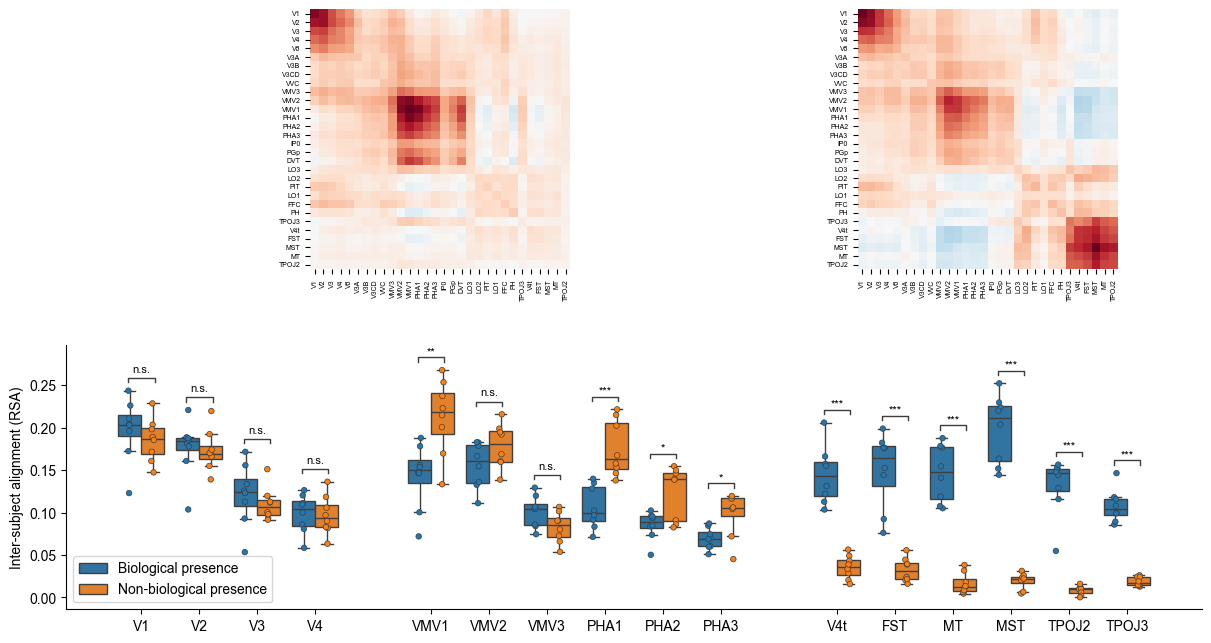

In [7]:
fig, axes = plt.subplot_mosaic(
    """
.A.B.
CCCCC
""",
    width_ratios=[1, 1.3, 1, 1.3, 0.2],
    height_ratios=[1.5, 1],
    figsize=(12, 7),
    constrained_layout=True,
)

ax = axes["C"]

sns.boxplot(
    data=df_boxplot.query("name in @rois"),
    x="name",
    y="similarity",
    hue="subset",
    ax=ax,
    order=rois,
    showfliers=False,
)
# Add individual points with jitter
sns.stripplot(
    data=df_boxplot.query("name in @rois"),
    x="name",
    y="similarity",
    hue="subset",
    ax=ax,
    order=rois,
    dodge=True,
    alpha=1,
    marker="o",
    size=4,
    edgecolor=(0.24, 0.24, 0.24),
    linewidth=0.5,
    jitter=0.05,
    legend=False,
)
ax.set_xlabel("")
ax.set_ylabel("Inter-subject alignment (RSA)")
ax.legend(title="")

i = 0
w = 0.23
p_values_indexed = pvalues.set_index("name")

df_max = df_boxplot.groupby(["name"]).similarity.max()
for i, name in enumerate(rois):
    if name.strip() == "":
        continue
    y = df_max.loc[name] + 0.01
    p_value = p_values_indexed.loc[name, "apa_star"]

    h = 0.012 if p_value == "n.s." else 0.008

    add_pvalue_bracket(
        ax=ax, x1=i - w, x2=i + w, y=y, height=0.005, text=str(p_value), y_text=y + h, fontsize=8
    )

ax.set_xticks([r for r in rois if r.strip() != ""])

sns.despine(ax=ax)

for ax1, df, title in [
    (axes["A"], df_pairwise_inanimate, "Inanimate"),
    (axes["B"], df_pairwise_animate, "Animate"),
]:
    vmax = 0.2
    sns.heatmap(
        df,
        ax=ax1,
        cbar=False,
        vmin=-vmax,
        center=0,
        vmax=vmax,
        cmap="RdBu_r",
        xticklabels=connectivity_order,
        yticklabels=connectivity_order,
        square=True,
    )
    # ax1.set_title(title)
    ax1.set_xlabel("")
    ax1.set_ylabel("")
    # Set small font size for tick labels
    ax1.tick_params(axis="both", which="major", labelsize=5)

# Change legend labels to Biological presence / Non-biological presence
handles, labels = axes["C"].get_legend_handles_labels()
axes["C"].legend(
    handles=handles,
    labels=["Biological presence", "Non-biological presence"],
    title="",
    loc="lower left",
)

filename = "01_panel_biology_split_rsa.pdf"
fig.savefig(output / filename, transparent=True, bbox_inches="tight")

## ROI‑wise Mean Alignment Table

Auxiliary table joining animate/inanimate mean alignment with HCP labels. Useful for reproducibility and for driving surface visualizations.


In [8]:
# Load partitions
df_diag = pd.read_parquet(filename_partitions)
df_diag = df_diag.query("subject_i != subject_j and roi_x == roi_y")
df_diag = df_diag.groupby(["roi_x", "subset"]).similarity.mean().reset_index()
df_diag = df_diag.rename(columns={"roi_x": "roi"})
hcp = pd.read_csv(hcp_filename)[["roi", "name", "mne_name"]]
df_diag = df_diag.merge(hcp, on="roi", how="left")
df_diag

,roi,subset,similarity,name,mne_name
0,1,animate,0.197385,V1,L_V1_ROI-lh
1,1,inanimate,0.185597,V1,L_V1_ROI-lh
2,2,animate,0.198725,MST,L_MST_ROI-lh
3,2,inanimate,0.019467,MST,L_MST_ROI-lh
4,3,animate,0.014626,V6,L_V6_ROI-lh
...,...,...,...,...,...
355,178,inanimate,0.000580,PI,L_PI_ROI-lh
356,179,animate,0.000980,a32pr,L_a32pr_ROI-lh
357,179,inanimate,0.002164,a32pr,L_a32pr_ROI-lh
358,180,animate,0.000936,p24,L_p24_ROI-lh


## Cortical Surface Maps

Project partition‑specific mean inter‑subject RSA onto `fsaverage` cortical surfaces (left hemisphere shown in lateral, ventral, medial views).  
Color scale: RdBu\_r, normalized to ±0.2 (zero‑centered).  
These maps spatially corroborate hub‑level effects: dorsal/LOTC regions brighten under biological stimuli, while ventral anterior regions emphasize non‑biological structure.


In [9]:
views = ["lateral", "ventral", "medial", "caudal"]
surface_folder = output / "02_brain_surfaces"
surface_folder.mkdir(exist_ok=True)
for column in ["animate", "inanimate"]:
    df_plot = df_diag.query("subset == @column")
    brain = plot_faverage_parcelation(
        df_plot,
        value_column="similarity",
        hemisphere="lh",
        cmap="RdBu_r",
        normalize=(-0.2, 0.2),
        default_color="lightgrey",
        default_value=None,
    )
    for view in views:
        brain.show_view(view)
        brain.save_image(surface_folder / f"rsa_{column}_0_2_{view}.png", mode="rgba")

    brain.close()

Inspect the brain surfaces

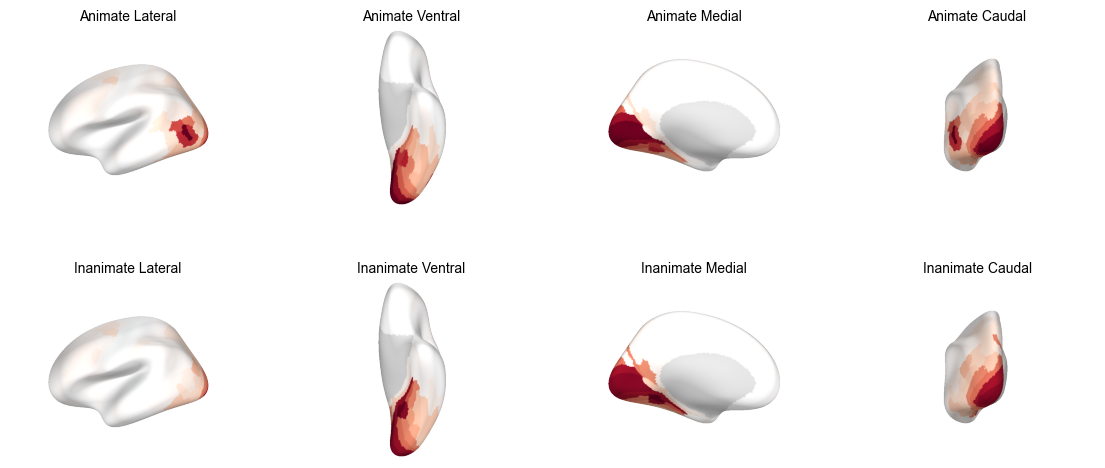

In [10]:
fig, axes = plt.subplots(2, len(views), figsize=(len(views) * 3.5, 6))
for i, column in enumerate(["animate", "inanimate"]):
    for j, view in enumerate(views):
        img_file = surface_folder / f"rsa_{column}_0_2_{view}.png"
        img = plt.imread(img_file)
        axes[i, j].imshow(img)
        axes[i, j].axis("off")
        axes[i, j].set_title(f"{column.title()} {view.capitalize()}", fontsize=10)

## Shared Colorbar

Export a standalone colorbar panel (“Inter‑subject alignment (RSA)”) for integration into figure composites, ensuring consistent scaling across manuscripts.


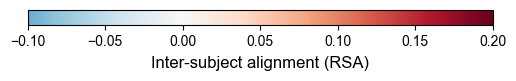

In [11]:
vmax = 0.2
filename = output / f"03_colorbar_biology_split_rsa_{vmax:.2f}.pdf"
plot_cbar_set(title="Inter-subject alignment (RSA)",
              filename=filename,
              vmax=vmax,
              vmin=-0.1,
              locator=0.05)

## Summary

This split‑dataset analysis demonstrates **content‑specific modulation** of representational convergence:
- **Biological stimuli** amplify inter‑subject alignment in motion/LOTC regions.
- **Non‑biological stimuli** preferentially enhance alignment within ventral semantic hubs.

These complementary patterns strengthen the interpretation that distinct cortical hubs specialize for different semantic axes of naturalistic vision.
